# Esercitazione 3

In questa esercitazione l'obiettivo è mostrare tramite una simulazione Monte Carlo la convergenza del prezzo di due opzioni Europee PlainVanilla call e put ai valori analitici secondo la teoria di Black e Scholes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
     if (code_show){  $('div.input').hide();
     }else {  $('div.input').show();}
     code_show = !code_show
     } 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 3.1

Lo scopo dell'esercizio è quello di stimare il prezzo per un'opzione plain vanilla di tipo call ($C[S(0),0]$) e di tipo put ($P[S(0),0]$), dato in generale dal valore di aspettazione del guadagno previsto al tempo $T$ per l'holder riscalato del fattore $e^{-rT}$ (prezzo attualizzato):

$$C[S(0),0]=e^{-rT}\max(S(T)-K,0)\,\,\,\,\text{e}\,\,\,\,P[S(0),0]=e^{-rT}\max(K-S(T),0)$$

dove $r$ rappresenta il tasso d'interesse fisso, $T$ la data di scadenza entro la quale l'opzione può essere esercitata e $K$ lo strike price, ossia il prezzo pattuito alla sottoscrizione del contratto al quale è possibile vendere/acquistare il sottostante al tempo $T$.
Sotto le assunzioni di mercato massivamente efficiente (nessuna frizione di mercato e infinita liquidità) e di prezzo dell'asset che evolve secondo un moto browniano geometrico a drift e volatilità costanti, valgono i risultati ottenuti da Black e Scholes. 
Questi valori analitici vengono calcolati nella cella successiva e vengono presi come valori di riferimento per il confronto con i risultati numerici.

In [4]:
import matplotlib.mlab as mlab
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt

S0 = 100.     # prezzo del titolo finanziario al tempo t = 0
K = 110.      # prezzo pattuito nel contratto
T = 1.        # tempo di chiusura del contratto
r = 0.1       # tasso di interesse
sigma = 0.25  # volatilità
t = 0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call_value, put_value = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK & SCHOLES ==")
    print("call: ", call_value)
    print("put: ", put_value)

 == BLACK & SCHOLES ==
call:  10.160052368788676
put:  9.692168352744218


**A)** In questa sezione viene stimato il prezzo finale delle due opzioni Europee Put e Call in modo diretto, ossia attraverso l'espressione dell'evoluzione di un moto browniano geometrico per il prezzo dell'asset $S\sim GBM(\mu,\sigma^2)$, con valore iniziale $S_0$:

$$S(t) = S_0 \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]\,\,\text{dove}\,\,W(t)\sim\mathcal{N}(0,t)$$

Viene simulato il prezzo delle due opzioni attraverso una procedura Monte Carlo per $10^5$ volte utilizzando il metodo del data blocking (con $100$ blocchi) per ottenere il valore medio del prezzo e la deviazione standard della media. I parametri usati per la simulazione sono i seguenti:
1. prezzo del titolo finanziario al tempo $t=0$: $S_0 = 100$;   
2. prezzo d'esercizio: $K = 110$;      
3. tempo di chiusura del contratto (data di scadenza): $T = 1$;
4. tasso di interesse costante $r = 0.1$;      
5. volatilità costante $\sigma = 0.25$;

I risultati numerici vengono rappresentati nei grafici sottostanti e mostrano un buon accordo con il valore teorico atteso.

In [2]:
call = np.loadtxt("continous_call.dat")
put = np.loadtxt("continous_put.dat")

x = np.arange(1,100,1)

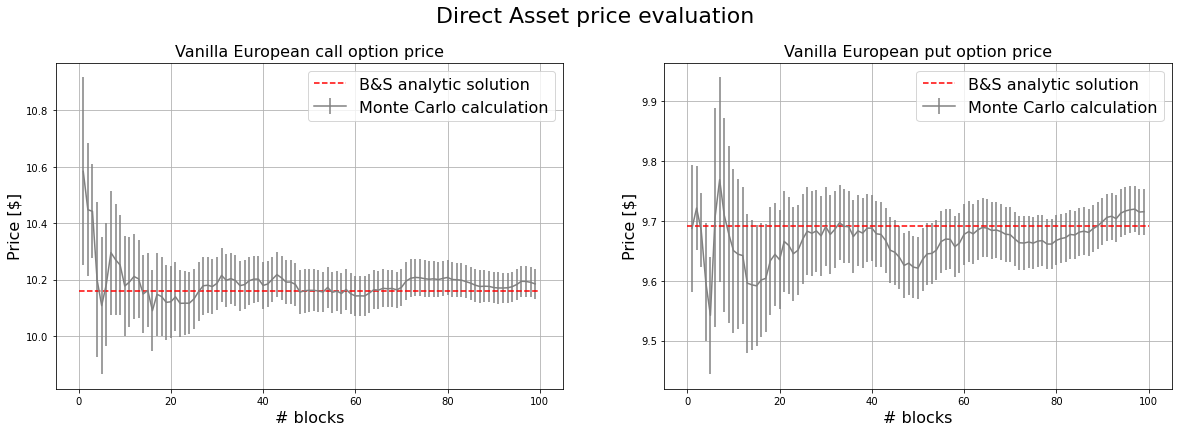

In [5]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Vanilla European call option price',fontsize=16)
plt.errorbar(x, call.T[0], yerr=call.T[1], color='grey', label='Monte Carlo calculation')
plt.hlines(call_value, 0, 100, color='red', linewidth=1.5, label='B&S analytic solution', linestyle='--')
plt.legend(fontsize=16)
plt.grid(True)
plt.xlabel('# blocks',fontsize=16)
plt.ylabel('Price [$]',fontsize=16)

plt.subplot(1,2,2)
plt.title('Vanilla European put option price',fontsize=16)
plt.errorbar(x, put.T[0], yerr=put.T[1], color='grey', label='Monte Carlo calculation')
plt.hlines(put_value, 0, 100, color='red', linewidth=1.5, label='B&S analytic solution', linestyle='--')
plt.legend(fontsize=16)
plt.grid(True)
plt.xlabel('# blocks',fontsize=16)
plt.ylabel('Price [$]',fontsize=16)

plt.suptitle('Direct Asset price evaluation', fontsize=22,y=1.01)
plt.show()

**B)** In questa seconda sezione viene stimato il prezzo finale delle due opzioni Europee Put e Call campionando il percorso discretizzato 𝐺𝐵𝑀(𝑟,$\sigma^2$) del prezzo del bene dividendo l'intervallo di tempo $[0,𝑇]$ in $100$ sotto-intervalli: $S_0=𝑆(0)$, $𝑆(𝑡_1)$, $𝑆(𝑡_2)$, ... fino a $𝑆(𝑡_{100}=𝑇=1)$:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]\,\,\,\text{con}\,\,\,Z_i \sim \mathcal{N}(0,1)$$

Viene simulato il prezzo delle due opzioni attraverso una procedura Monte Carlo per $10^5$ volte utilizzando il metodo del data blocking (con blocchi da $10^3$ misure ciascuno) per ottenere il valore medio del prezzo e la deviazione standard della media. I valori dei parametri usati per la simulazione sono quelli utilizzati nella prima parte dell'esercizio.

I risultati numerici vengono rappresentati nei grafici sottostanti e mostrano un buon accordo con il valore teorico atteso.

In [6]:
call1 = np.loadtxt("discrete_call.dat")
put1 = np.loadtxt("discrete_put.dat")

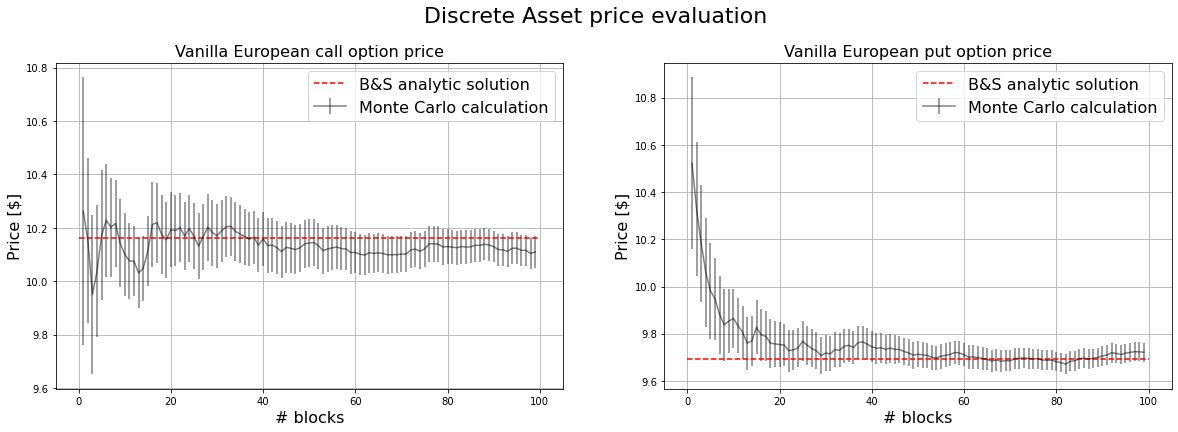

In [7]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Vanilla European call option price',fontsize=16)
plt.errorbar(x, call1.T[0], yerr=call1.T[1], color='black', alpha=0.5, label='Monte Carlo calculation')
plt.hlines(call_value, 0, 100, color='red', linewidth=1.5, label='B&S analytic solution', linestyle='--')
plt.legend(loc='upper right',fontsize=16)
plt.xlabel('# blocks',fontsize=16)
plt.ylabel('Price [$]',fontsize=16)
plt.grid(True)

plt.subplot(1,2,2)
plt.title('Vanilla European put option price',fontsize=16)
plt.errorbar(x, put1.T[0], yerr=put1.T[1], color='black', alpha=0.5, label='Monte Carlo calculation')
plt.hlines(put_value, 0, 100, color='red', linewidth=1.5, label='B&S analytic solution', linestyle='--')
plt.legend(loc='upper right',fontsize=16)
plt.xlabel('# blocks',fontsize=16)
plt.ylabel('Price [$]',fontsize=16)
plt.grid(True)

plt.suptitle('Discrete Asset price evaluation', fontsize=22 ,y=1.01)
plt.show()